In [1]:
import cks.initialize as initialize
import cks.evolve as evolve
import pylab as pl
import arrayfire as af
import params
af.set_backend("cpu")

% matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['figure.dpi']      = 300
pl.rcParams['image.cmap']      = 'jet'
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in' 

In [3]:
config = initialize.set(params)

In [4]:
x     = initialize.calculate_x(config)
vel_x = initialize.calculate_vel_x(config)
y     = initialize.calculate_y(config)
vel_y = initialize.calculate_vel_y(config)

In [5]:
f_initial  = initialize.f_initial(config)
time_array = initialize.time_array(config)

In [6]:
class args:
    pass

args.config = config
args.f      = f_initial
args.vel_x  = vel_x
args.vel_y  = vel_y
args.x      = x
args.y      = y

In [7]:
dx = af.sum(x[0, 1, 0, 0] - x[0, 0, 0, 0])
dy = af.sum(y[1, 0, 0, 0] - y[0, 0, 0, 0])

N_x = config.N_x
N_y = config.N_y

N_ghost_x = config.N_ghost_x
N_ghost_y = config.N_ghost_y

E_x_local, E_y_local = evolve.fft_poisson(config.charge_particle*evolve.calculate_density(args)[3:-4, 3:-4], dx, dy)

E_x_local = af.join(0, E_x_local, E_x_local[0])
E_x_local = af.join(1, E_x_local, E_x_local[:, 0])

E_y_local = af.join(0, E_y_local, E_y_local[0])
E_y_local = af.join(1, E_y_local, E_y_local[:, 0])

E_x_local.shape

E_x = af.constant(0, N_y + 2*N_ghost_y, N_x + 2*N_ghost_x, dtype=af.Dtype.c64)
E_y = af.constant(0, N_y + 2*N_ghost_y, N_x + 2*N_ghost_x, dtype=af.Dtype.c64)

E_x[N_ghost_y:-N_ghost_y, N_ghost_x:-N_ghost_x] = E_x_local
E_x                                             = evolve.periodic_x(config, E_x)
E_x                                             = evolve.periodic_y(config, E_x)

E_y[N_ghost_y:-N_ghost_y, N_ghost_x:-N_ghost_x] = E_y_local
E_y                                             = evolve.periodic_x(config, E_y)
E_y                                             = evolve.periodic_y(config, E_y)

args.E_x = af.real(E_x)
args.E_y = af.real(E_y)
args.B_z = af.constant(0, E_x.shape[0], E_x.shape[1], dtype=af.Dtype.f64)

In [8]:
# data, f_final = evolve.time_integration(args, time_array)

In [9]:
# pl.plot(time_array, data)
# pl.xlabel('Time')
# pl.ylabel(r'$MAX(\delta \rho(x))$')

/home/hyperion/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:2720: ComplexWarning: Casting complex values to real discards the imaginary part
  order=order, subok=True, ndmin=ndmin)


(9.613562499933318e-18+1.6866762835049783e-33j)


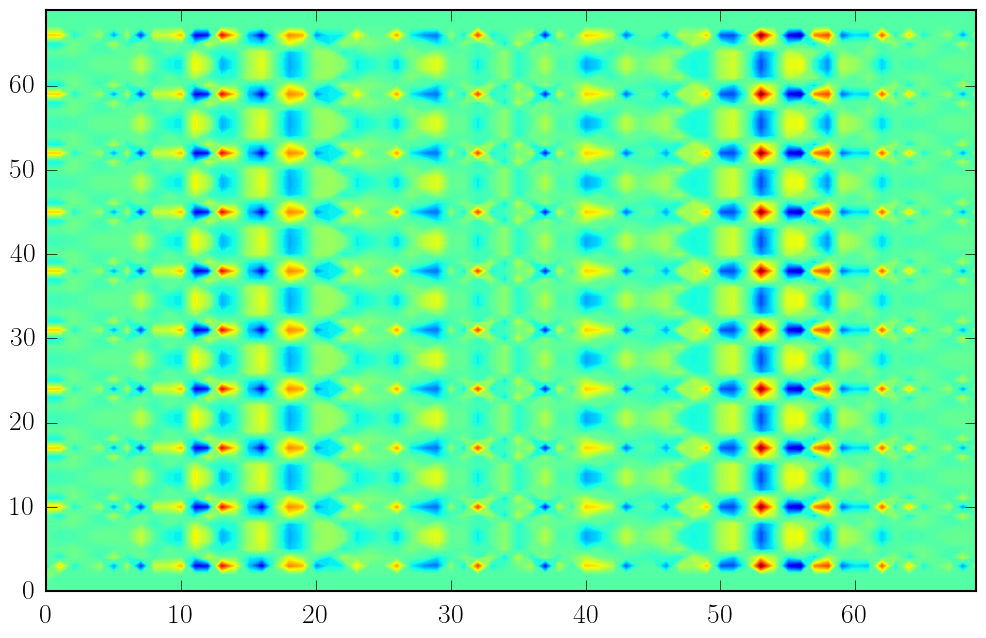

In [12]:
import numpy as np
pl.contourf(np.array(E_x), 100)